In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
import xgboost as xgb
import datetime

In [26]:
train = pd.read_csv('train_c.csv', parse_dates=['timestamp'])
test = pd.read_csv('test_c.csv', parse_dates=['timestamp'])
macro = pd.read_csv('macro.csv', parse_dates=['timestamp'])
id_test = test.id

## Extra Feature Engineering

In [27]:
## Extra Data Cleansing and Feature Engineering
#multiplier = 0.969

#clean data
bad_index = train[train.life_sq > train.full_sq].index
train.ix[bad_index, "life_sq"] = np.NaN
equal_index = [601,1896,2791]
test.ix[equal_index, "life_sq"] = test.ix[equal_index, "full_sq"]
bad_index = test[test.life_sq > test.full_sq].index
test.ix[bad_index, "life_sq"] = np.NaN
bad_index = train[train.life_sq < 5].index
train.ix[bad_index, "life_sq"] = np.NaN
bad_index = test[test.life_sq < 5].index
test.ix[bad_index, "life_sq"] = np.NaN
bad_index = train[train.full_sq < 5].index
train.ix[bad_index, "full_sq"] = np.NaN
bad_index = test[test.full_sq < 5].index
test.ix[bad_index, "full_sq"] = np.NaN
kitch_is_build_year = [13117]
train.ix[kitch_is_build_year, "build_year"] = train.ix[kitch_is_build_year, "kitch_sq"]
bad_index = train[train.kitch_sq >= train.life_sq].index
train.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = test[test.kitch_sq >= test.life_sq].index
test.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = train[(train.kitch_sq == 0).values + (train.kitch_sq == 1).values].index
train.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = test[(test.kitch_sq == 0).values + (test.kitch_sq == 1).values].index
test.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = train[(train.full_sq > 210) & (train.life_sq / train.full_sq < 0.3)].index
train.ix[bad_index, "full_sq"] = np.NaN
bad_index = test[(test.full_sq > 150) & (test.life_sq / test.full_sq < 0.3)].index
test.ix[bad_index, "full_sq"] = np.NaN
bad_index = train[train.life_sq > 300].index
train.ix[bad_index, ["life_sq", "full_sq"]] = np.NaN
bad_index = test[test.life_sq > 200].index
test.ix[bad_index, ["life_sq", "full_sq"]] = np.NaN
train.product_type.value_counts(normalize= True)
test.product_type.value_counts(normalize= True)
bad_index = train[train.build_year < 1500].index
train.ix[bad_index, "build_year"] = np.NaN
bad_index = test[test.build_year < 1500].index
test.ix[bad_index, "build_year"] = np.NaN
bad_index = train[train.num_room == 0].index 
train.ix[bad_index, "num_room"] = np.NaN
bad_index = test[test.num_room == 0].index 
test.ix[bad_index, "num_room"] = np.NaN
bad_index = [10076, 11621, 17764, 19390, 24007, 26713, 29172]
train.ix[bad_index, "num_room"] = np.NaN
bad_index = [3174, 7313]
test.ix[bad_index, "num_room"] = np.NaN
bad_index = train[(train.floor == 0).values * (train.max_floor == 0).values].index
train.ix[bad_index, ["max_floor", "floor"]] = np.NaN
bad_index = train[train.floor == 0].index
train.ix[bad_index, "floor"] = np.NaN
bad_index = train[train.max_floor == 0].index
train.ix[bad_index, "max_floor"] = np.NaN
bad_index = test[test.max_floor == 0].index
test.ix[bad_index, "max_floor"] = np.NaN
bad_index = train[train.floor > train.max_floor].index
train.ix[bad_index, "max_floor"] = np.NaN
bad_index = test[test.floor > test.max_floor].index
test.ix[bad_index, "max_floor"] = np.NaN
train.floor.describe(percentiles= [0.9999])
bad_index = [23584]
train.ix[bad_index, "floor"] = np.NaN
train.material.value_counts()
test.material.value_counts()
train.state.value_counts()
bad_index = train[train.state == 33].index
train.ix[bad_index, "state"] = np.NaN
test.state.value_counts()

# brings error down a lot by removing extreme price per sqm
train.loc[train.full_sq == 0, 'full_sq'] = 50
train = train[train.price_doc/train.full_sq <= 600000]
train = train[train.price_doc/train.full_sq >= 10000]

In [28]:
# Add month-year
month_year = (train.timestamp.dt.month + train.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
train['month_year_cnt'] = month_year.map(month_year_cnt_map)

month_year = (test.timestamp.dt.month + test.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
test['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (train.timestamp.dt.weekofyear + train.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
train['week_year_cnt'] = week_year.map(week_year_cnt_map)

week_year = (test.timestamp.dt.weekofyear + test.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
test['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
train['month'] = train.timestamp.dt.month
train['dow'] = train.timestamp.dt.dayofweek

test['month'] = test.timestamp.dt.month
test['dow'] = test.timestamp.dt.dayofweek

# Other feature engineering
train['rel_floor'] = train['floor'] / train['max_floor'].astype(float)
train['rel_kitch_sq'] = train['kitch_sq'] / train['full_sq'].astype(float)

test['rel_floor'] = test['floor'] / test['max_floor'].astype(float)
test['rel_kitch_sq'] = test['kitch_sq'] / test['full_sq'].astype(float)

train['room_size'] = train['life_sq'] / train['num_room'].astype(float)
test['room_size'] = test['life_sq'] / test['num_room'].astype(float)


## Load Location Data

In [29]:
train_location = pd.read_csv('train_lat_lon.csv')
test_location = pd.read_csv('test_lat_lon.csv')
col = ['id','lat','lon']
train_location = train_location[col]
test_location = test_location[col]

In [30]:
train = train.merge(train_location,how='left',on='id')
test = test.merge(test_location,how='left',on='id')

In [32]:
col = list(test.columns)[2:]

In [34]:
label =train['price_doc']*0.969 + 10

In [35]:
dtrain = xgb.DMatrix(train[col],label)
dtest = xgb.DMatrix(test[col])

In [36]:
params = {
    'eta': 0.05, ## Try 0.01,3,5
    'max_depth': 5,## Try 4,5,6
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

[0]	train-rmse:7.944e+06	test-rmse:7.94942e+06
[50]	train-rmse:2.38161e+06	test-rmse:2.70116e+06
[100]	train-rmse:2.06254e+06	test-rmse:2.5223e+06
[150]	train-rmse:1.94153e+06	test-rmse:2.47683e+06
[200]	train-rmse:1.85092e+06	test-rmse:2.45406e+06
[250]	train-rmse:1.78345e+06	test-rmse:2.44179e+06
[300]	train-rmse:1.72373e+06	test-rmse:2.43153e+06
[350]	train-rmse:1.67039e+06	test-rmse:2.42529e+06
[400]	train-rmse:1.62116e+06	test-rmse:2.422e+06
[450]	train-rmse:1.57713e+06	test-rmse:2.4194e+06
[500]	train-rmse:1.53717e+06	test-rmse:2.41654e+06
[550]	train-rmse:1.49772e+06	test-rmse:2.41534e+06
[600]	train-rmse:1.45973e+06	test-rmse:2.41454e+06
Performance does not improve from 600 rounds


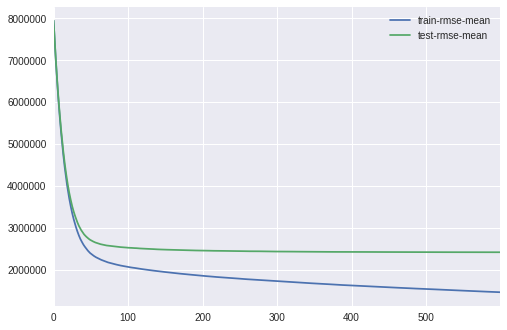

In [37]:
xgb_cvalid = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False,seed=42)
xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

In [38]:
model1 = xgb.train(params,dtrain,num_boost_round=len(xgb_cvalid))

In [39]:
pred = model1.predict(dtest)

In [41]:
def get_feature_importance(model):
    Importance = model.get_fscore()
    Importance = list(Importance.items())
    Feature= []
    Score = []
    for each in Importance:
        Feature.append(each[0])
        Score.append(each[1])
    df = pd.DataFrame({'Feature':Feature,'Score':Score}).sort_values(by=['Score'],ascending=[0])
    return df    

In [42]:
def plot_importance(model):
    FImportance = get_feature_importance(model).iloc[0:50,]
    plt.figure()
    FImportance.plot(kind='barh', x='Feature', y='Score', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.show()

In [44]:
FScore = get_feature_importance(model1)

In [47]:
pred = model1.predict(dtest)

In [48]:
sub = pd.DataFrame({"id":test['id'],'price_doc':pred})

In [49]:
sub.to_csv('AddLocationAndFE.csv',index=False)

## Without Extra Feature Engineering

In [51]:
train = pd.read_csv('train_c.csv')
test = pd.read_csv('test_c.csv')

In [52]:
train = train.merge(train_location,how='left',on='id')
test = test.merge(test_location,how='left',on='id')

In [53]:
col = list(test.columns)[2:]

In [54]:
label =train['price_doc']*0.969 + 10

In [55]:
dtrain = xgb.DMatrix(train[col],label)
dtest = xgb.DMatrix(test[col])

In [56]:
params = {
    'eta': 0.05, ## Try 0.01,3,5
    'max_depth': 5,## Try 4,5,6
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

[0]	train-rmse:7.9515e+06	test-rmse:7.95593e+06
[50]	train-rmse:2.44482e+06	test-rmse:2.82272e+06
[100]	train-rmse:2.11851e+06	test-rmse:2.65266e+06
[150]	train-rmse:2.00486e+06	test-rmse:2.61636e+06
[200]	train-rmse:1.92623e+06	test-rmse:2.5979e+06
[250]	train-rmse:1.85671e+06	test-rmse:2.58668e+06
[300]	train-rmse:1.79564e+06	test-rmse:2.58115e+06
[350]	train-rmse:1.74364e+06	test-rmse:2.57884e+06
[400]	train-rmse:1.69608e+06	test-rmse:2.57713e+06
Performance does not improve from 386 rounds


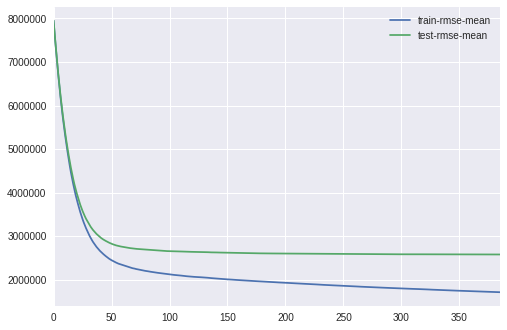

In [57]:
xgb_cvalid = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False,seed=42)
xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

In [58]:
model2 = xgb.train(params,dtrain,num_boost_round=len(xgb_cvalid))

In [59]:
pred2 = model2.predict(dtest)

In [60]:
pred2

array([ 5456305. ,  8103837. ,  5204580.5, ...,  4988548. ,  5239221. ,
        8697876. ], dtype=float32)

In [61]:
sub = pd.DataFrame({"id":test['id'],'price_doc':pred2})

In [62]:
sub.to_csv('AddLocationNoFE.csv',index=False)

## No Additional Features at all

In [63]:
train = pd.read_csv('train_c.csv')
test = pd.read_csv('test_c.csv')

In [64]:
col = list(test.columns)[2:]

In [67]:
dtrain = xgb.DMatrix(train[col],label)
dtest = xgb.DMatrix(test[col])

[0]	train-rmse:7.95171e+06	test-rmse:7.95638e+06
[50]	train-rmse:2.44488e+06	test-rmse:2.82164e+06
[100]	train-rmse:2.1207e+06	test-rmse:2.64987e+06
[150]	train-rmse:2.01099e+06	test-rmse:2.61654e+06
[200]	train-rmse:1.92819e+06	test-rmse:2.5982e+06
[250]	train-rmse:1.85678e+06	test-rmse:2.58669e+06
[300]	train-rmse:1.79951e+06	test-rmse:2.58163e+06
[350]	train-rmse:1.74695e+06	test-rmse:2.57548e+06
Performance does not improve from 372 rounds


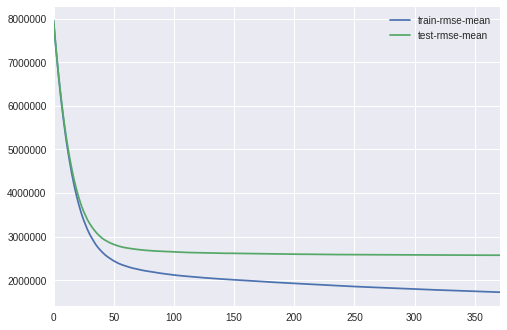

In [68]:
xgb_cvalid = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False,seed=42)
xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

In [69]:
model3 = xgb.train(params,dtrain,num_boost_round=len(xgb_cvalid))

In [70]:
pred3 = model3.predict(dtest)

## Ensemble Models

In [76]:
Average_Price = np.exp(np.log(pred3)*0.6 +
                               np.log(pred2)*.2+
                               np.log(pred)*.2)

In [77]:
sub = pd.DataFrame({'id':test['id'],'price_doc':Average_Price})
sub.to_csv('AverageThreeWithLocations.csv',index=False)

In [75]:
Average_Price

array([ 5389729.5,  8125553. ,  5201663. , ...,  4615385. ,  5100465.5,
        8419188. ], dtype=float32)